In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tkinter as tk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import cv2
from skimage.segmentation import slic, mark_boundaries
from skimage.util import img_as_float
import ipywidgets as widgets
from IPython.display import display
import os


# carregar imagem
img = 'image'
img_path = 'images/' + img + '.jpg'  
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = img_as_float(image)

# segmentar com slic
def segment_image(n_segments=100, compactness=10):
    return slic(image, n_segments=n_segments, compactness=compactness, start_label=1)

def update_segmentation(n_segments, compactness):
    global segments
    segments = segment_image(n_segments=n_segments, compactness=compactness)
    with out:
        out.clear_output(wait=True)
        fig, ax = plt.subplots()
        ax.imshow(mark_boundaries(image, segments))
        ax.axis('off')
        plt.show()

# Configurar os widgets
slider_segments = widgets.IntSlider(value=100, min=10, max=500, step=10, description='Segments')
slider_compactness = widgets.FloatSlider(value=10, min=0.1, max=50, step=0.1, description='Compactness')

# Função interativa para atualização
interactive_segmentation = widgets.interactive(update_segmentation, n_segments=slider_segments, compactness=slider_compactness)

out = widgets.Output()
display(slider_segments, slider_compactness, out)

# segmentação interativa
segments = segment_image()
update_segmentation(slider_segments.value, slider_compactness.value)


IntSlider(value=100, description='Segments', max=500, min=10, step=10)

FloatSlider(value=10.0, description='Compactness', max=50.0, min=0.1)

Output()

Máscara salva em: masks/image_mask.png


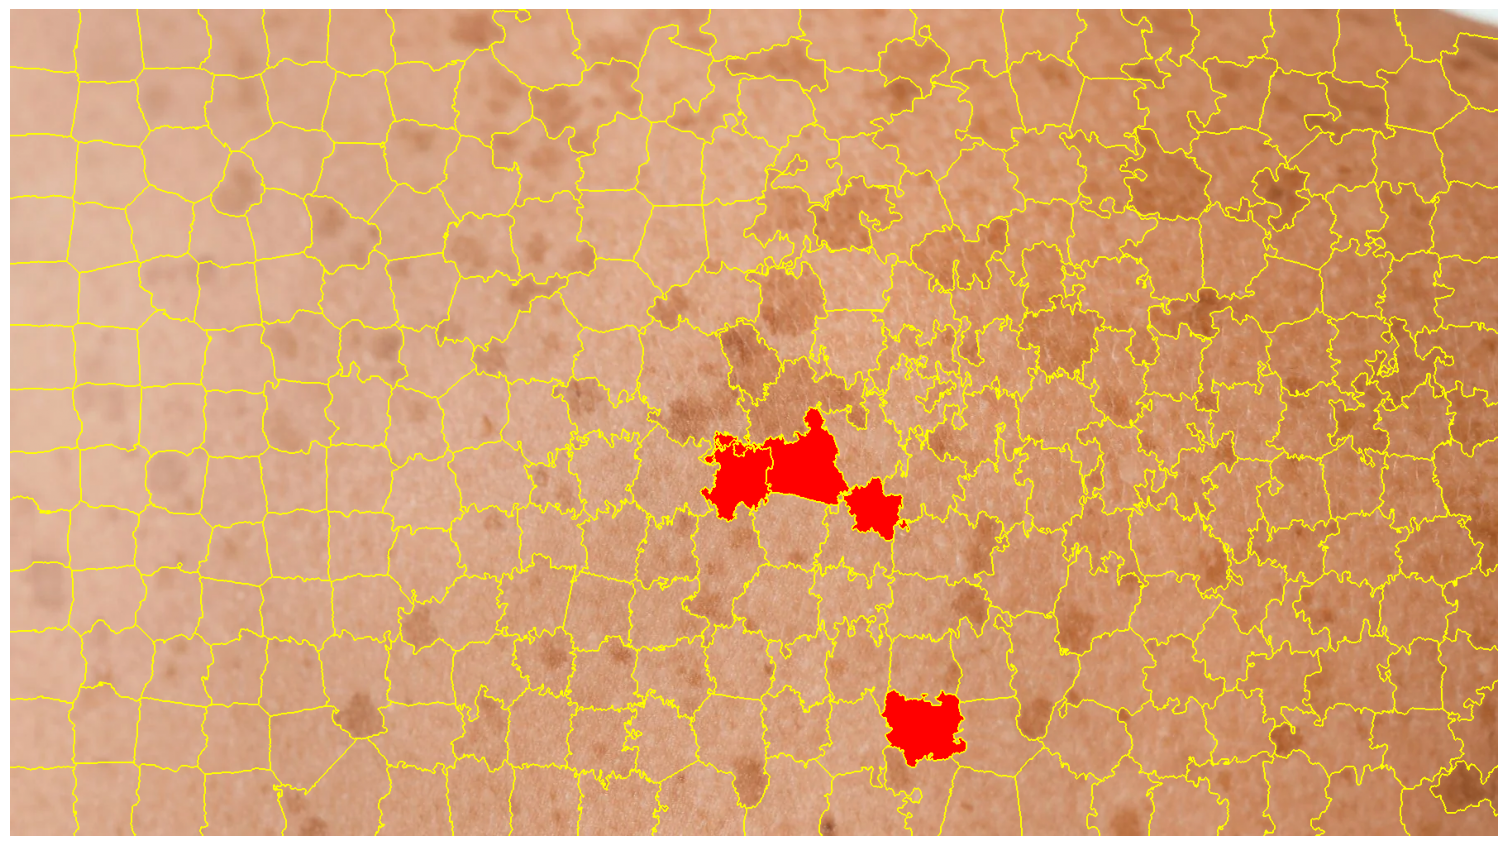

In [3]:
clicks = []
selected_segments = []

def on_click(event):
    if event.xdata is not None and event.ydata is not None:
        x, y = int(event.xdata), int(event.ydata)
        segment_id = segments[y, x]
        if segment_id not in selected_segments:
            selected_segments.append(segment_id)
        clicks.append((x, y))
        update_display()

def update_display():
    highlighted_image = image.copy()
    for segment_id in selected_segments:
        highlighted_image[segments == segment_id] = [1, 0, 0]
    ax.clear()
    ax.imshow(mark_boundaries(highlighted_image, segments))
    ax.axis('off')
    canvas.draw()

def save_mask():
    mask = np.zeros(segments.shape, dtype=np.uint8)
    for segment_id in selected_segments:
        mask[segments == segment_id] = 255 
    mask_path = 'masks/' + img + '_mask.png'
    
    if not os.path.exists('masks'):
        os.makedirs('masks')

    if os.path.exists(mask_path):
        os.remove(mask_path)

    plt.imsave(mask_path, mask, cmap='gray')
    print(f'Máscara salva em: {mask_path}')

# tkinter
root = tk.Tk()
root.title("Seleção de Regiões Segmentadas")

fig, ax = plt.subplots()
canvas = FigureCanvasTkAgg(fig, master=root)
canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=1)

canvas.mpl_connect('button_press_event', on_click)
ax.imshow(mark_boundaries(image, segments))
ax.axis('off')

button_save = tk.Button(master=root, text="Save Mask", command=save_mask)
button_save.pack(side=tk.BOTTOM)

tk.mainloop()